<a href="https://colab.research.google.com/github/Laura9704/Fundamentos_MCD/blob/main/Codigo_taller.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**FA II 2025-II: Pronósticos NN-RNN-LSTM-TCN
Taller final sobre Fundamentos de Analítica II en Maestría de Ciencia de Datos de la Universidad ICESI**

2. Modelo con Redes Neuronales Tradicionales (MLP):
El estudiante implementa un Perceptrón Multicapa (MLP) para el pronóstico de series de tiempo, realizando cambios en al menos tres hiperparámetros de la arquitectura respecto al código base entregado, con el fin de optimizar su desempeño y asegurando la correcta separación de los conjuntos de datos para evitar fuga de información

#Libreria

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

pd.set_option('display.max_columns', None)

import matplotlib.pyplot as plt #gráficos
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from math import sqrt

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
import random
import os

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
if torch.cuda.is_available():
    print("Utilizamos la primera GPU disponible")
    DEVICE=device = torch.device('cuda:0')
    os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
else:
    print("No hay GPU, toca correr todo en CPU")
    DEVICE=device = torch.device('cpu')

DEVICE

No hay GPU, toca correr todo en CPU


device(type='cpu')

In [ ]:
os.environ["CUDA_LAUNCH_BLOCKING"] = "1" if torch.cuda.is_available() else "0"

In [ ]:
def reset_seed():
    SEED = 42
    torch.backends.cudnn.enabled = True
    torch.manual_seed(SEED)
    np.random.seed(SEED)
    random.seed(SEED)

    if torch.cuda.is_available():
        torch.cuda.manual_seed(SEED)
        torch.cuda.manual_seed_all(SEED)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

In [ ]:
reset_seed()

In [ ]:
# --- PASO 0: Instalar librerías para archivos Parquet ---
# Pyarrow es la librería más común y estable para leer Parquet con Pandas.
print("0. Instalando librería 'pyarrow' para leer archivos Parquet...")
!pip install pyarrow --quiet
print("Instalación completada.\n")


0. Instalando librería 'pyarrow' para leer archivos Parquet...
Instalación completada.



# Cargamos los datos

## Cargar desde Kaggle

In [ ]:
'''
from google.colab import files
files.upload()
'''

'\nfrom google.colab import files\nfiles.upload()\n'

In [ ]:
'''
import sys
!mkdir -p ~/.kaggle
!mv "kaggle (1).json" ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json
import zipfile
# --- PASO 1: Descargar y Descomprimir ---
competition_name = 'fa-ii-2025-ii-pronosticos-nn-rnn-lstm-tcn'
zip_file_name = f'{competition_name}.zip'

print(f"1. Descargando datos de la competición: {competition_name}...")
# El comando !kaggle descarga el archivo ZIP. El flag -p /content/ lo coloca en la raíz.
!kaggle competitions download -c {competition_name} -p /content/

# Descomprimir el archivo ZIP
print(f"2. Descomprimiendo archivos...")
try:
    with zipfile.ZipFile(zip_file_name, 'r') as zip_ref:
        # Extraer todo el contenido a la carpeta actual (/content/)
        zip_ref.extractall('/content/')
    print("Descompresión completada. Archivos Parquet listos.")
except FileNotFoundError:
    print(f"\n[ERROR] No se encontró el archivo ZIP: {zip_file_name}")
    print("Asegúrate de que la descarga fue exitosa.")
    exit()

# --- PASO 2: Cargar df_train y df_test usando pd.read_parquet ---
try:
    # Cargar el set de entrenamiento
    df_train = pd.read_parquet('df_train.parquet')
    print(f"\n3. df_train cargado (Parquet). Shape: {df_train.shape}")

    # Cargar el set de prueba (test)
    df_test = pd.read_parquet('df_test.parquet')
    print(f"   df_test cargado (Parquet). Shape: {df_test.shape}")

except Exception as e:
    print("\n[ERROR] No se pudieron cargar 'df_train.parquet' o 'df_test.parquet'.")
    print(f"Detalle del error: {e}")
    '''

'\nimport sys\n!mkdir -p ~/.kaggle\n!mv "kaggle (1).json" ~/.kaggle/kaggle.json\n!chmod 600 ~/.kaggle/kaggle.json\nimport zipfile\n# --- PASO 1: Descargar y Descomprimir ---\ncompetition_name = \'fa-ii-2025-ii-pronosticos-nn-rnn-lstm-tcn\'\nzip_file_name = f\'{competition_name}.zip\'\n\nprint(f"1. Descargando datos de la competición: {competition_name}...")\n# El comando !kaggle descarga el archivo ZIP. El flag -p /content/ lo coloca en la raíz.\n!kaggle competitions download -c {competition_name} -p /content/\n\n# Descomprimir el archivo ZIP\nprint(f"2. Descomprimiendo archivos...")\ntry:\n    with zipfile.ZipFile(zip_file_name, \'r\') as zip_ref:\n        # Extraer todo el contenido a la carpeta actual (/content/)\n        zip_ref.extractall(\'/content/\')\n    print("Descompresión completada. Archivos Parquet listos.")\nexcept FileNotFoundError:\n    print(f"\n[ERROR] No se encontró el archivo ZIP: {zip_file_name}")\n    print("Asegúrate de que la descarga fue exitosa.")\n    exit()

In [ ]:
#df=df_train.copy()

## CARGA DE ARCHIVOS DESDE DRIVE

In [ ]:
# CARGAR df_train.parquet
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')
file_path = '/content/drive/My Drive/MCD/MCD_FDA_II/TALLER 2_RNN/fa-ii-2025-ii-pronosticos-nn-rnn-lstm-tcn/df_train.parquet'
df = pd.read_parquet(file_path)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Imputacion de datos

**Diferencias entre imputación por media estacional e interpolación**

**Imputación por media estacional**

Qué hace: Reemplaza valores faltantes con el promedio de valores observados en la misma estación/período (por ejemplo, todos los eneros, o todos los lunes, o la misma semana del año)
Supuesto: Los datos tienen patrones estacionales recurrentes y el valor faltante debería parecerse al comportamiento típico de ese período
Resultado: Introduce un valor "promedio" o "típico" que no considera la tendencia local ni los valores inmediatamente adyacentes
Ventaja: Preserva patrones estacionales y es útil cuando hay ciclos claros (temperatura, ventas navideñas)
Desventaja: Ignora la continuidad temporal local; puede crear saltos bruscos si el período actual es atípico

**Interpolación**

Qué hace: Estima valores faltantes basándose en los valores observados más cercanos en el tiempo (anterior y posterior)
Supuesto: Existe continuidad temporal y el valor faltante debería ser una transición suave entre sus vecinos
Métodos comunes: Lineal (línea recta entre puntos), spline (curva suave), polinomial
Resultado: Crea una transición continua que respeta la tendencia local
Ventaja: Mantiene la continuidad de la serie y refleja mejor cambios graduales o tendencias
Desventaja: No considera patrones estacionales; puede fallar si hay cambios abruptos reales

In [ ]:
rango_filtrado = df[(df['date'] >= '2002-04-10') & (df['date'] <= '2002-05-04')]
rango_filtrado

,date,min_temp,avg_temp,max_temp,min_rel_humidity,avg_rel_humidity,max_rel_humidity,solar_radiation,evapotranspiration,precipitation,year,precipitation_ma21,precipitation_ma7,precipitation_ma14,precipitation_ma30,precipitation_ma5
830,2002-04-10,19.3,22.7,28.7,50.0,83.0,100.0,450.1,4.8,0.0,2002,6.776190,9.900000,5.142857,5.083333,13.74
831,2002-04-11,18.9,23.2,30.3,34.0,77.0,99.0,556.5,5.5,0.0,2002,5.804762,9.900000,4.985714,5.083333,13.74
832,2002-04-12,20.5,24.3,30.7,33.0,68.0,86.0,542.3,5.3,0.0,2002,5.804762,9.814286,4.985714,5.076667,4.54
833,2002-04-13,19.2,23.3,30.4,38.0,74.0,97.0,525.3,5.0,0.0,2002,4.800000,9.814286,4.985714,4.933333,0.02
834,2002-04-14,17.1,23.2,30.6,40.0,75.0,97.0,519.7,5.0,0.2,2002,4.785714,3.271429,5.000000,4.916667,0.04
835,2002-04-15,18.7,22.8,28.3,51.0,84.0,100.0,371.8,4.1,5.5,2002,5.047619,0.828571,5.357143,5.100000,1.14
836,2002-04-16,20.0,24.2,31.2,47.0,80.0,100.0,452.0,4.9,0.0,2002,5.047619,0.814286,5.357143,4.933333,1.14
837,2002-04-17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,2002,3.700000,0.814286,5.357143,4.933333,1.14
838,2002-04-18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,2002,3.595238,0.814286,5.357143,4.933333,1.14
839,2002-04-19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,2002,3.595238,0.814286,5.314286,4.933333,1.10


In [ ]:
rango_filtrado = df[(df['date'] >= '2015-05-01') & (df['date'] <= '2017-06-01')]
rango_filtrado

,date,min_temp,avg_temp,max_temp,min_rel_humidity,avg_rel_humidity,max_rel_humidity,solar_radiation,evapotranspiration,precipitation,year,precipitation_ma21,precipitation_ma7,precipitation_ma14,precipitation_ma30,precipitation_ma5
5583,2015-05-01,20.3,23.7,30.0,44.0,72.0,90.0,410.2,NaN,0.0,2015,3.928571,0.000000,4.807143,2.886667,0.0
5584,2015-05-02,18.3,23.8,29.3,47.0,73.0,94.0,406.7,NaN,0.0,2015,3.928571,0.000000,4.807143,2.886667,0.0
5585,2015-05-03,19.8,22.9,27.5,50.0,78.0,92.0,312.0,NaN,2.5,2015,4.047619,0.357143,2.242857,2.966667,0.5
5586,2015-05-04,17.4,23.8,31.7,36.0,73.0,97.0,592.3,NaN,0.0,2015,4.047619,0.357143,0.185714,2.950000,0.5
5587,2015-05-05,19.7,25.0,31.9,36.0,68.0,92.0,550.7,NaN,0.0,2015,4.042857,0.357143,0.178571,2.950000,0.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6341,2017-05-28,18.3,24.1,30.8,44.0,76.0,99.0,397.1,NaN,0.0,2017,4.176190,1.085714,3.728571,5.090000,0.0
6342,2017-05-29,19.9,24.0,30.5,45.0,77.0,97.0,390.6,NaN,0.0,2017,4.119048,0.000000,1.421429,5.070000,0.0
6343,2017-05-30,18.4,23.9,30.2,48.0,76.0,98.0,379.9,NaN,0.0,2017,3.933333,0.000000,0.685714,4.423333,0.0
6344,2017-05-31,20.2,23.8,28.3,60.0,79.0,96.0,277.9,NaN,0.0,2017,3.533333,0.000000,0.685714,4.410000,0.0


In [ ]:
df_imputado = df.copy()

In [ ]:
# Asegurarse de que el índice es de tipo fecha (DatetimeIndex) para usar method='time'
# Si su columna de fecha se llama 'date', ejecute esto primero:
df_imputado = df_imputado.set_index('date')
df_imputado.index = pd.to_datetime(df_imputado.index)

In [ ]:
df_imputado.head()

,min_temp,avg_temp,max_temp,min_rel_humidity,avg_rel_humidity,max_rel_humidity,solar_radiation,evapotranspiration,precipitation,year,precipitation_ma21,precipitation_ma7,precipitation_ma14,precipitation_ma30,precipitation_ma5
date,,,,,,,,,,,,,,,
2000-01-01,20.1,23.1,27.5,57.0,77.0,95.0,308.1,2.8,0.0,2000,NaN,NaN,NaN,NaN,NaN
2000-01-02,19.2,22.0,26.7,58.0,82.0,98.0,343.1,4.1,0.0,2000,NaN,NaN,NaN,NaN,NaN
2000-01-03,18.0,21.7,28.8,51.0,80.0,98.0,456.1,4.5,2.1,2000,NaN,NaN,NaN,NaN,NaN
2000-01-04,17.8,21.9,27.1,50.0,74.0,90.0,391.5,3.8,0.0,2000,NaN,NaN,NaN,NaN,NaN
2000-01-05,19.0,22.3,27.4,51.0,76.0,95.0,348.4,3.9,0.0,2000,NaN,NaN,NaN,NaN,0.42


In [ ]:
# Definir un umbral superior basado en el conocimiento del dominio.
# Si 6999 es claramente un error, podemos usar un umbral conservador (e.g., 20)
UMBRAL_SUPERIOR = 20

# Reemplazar el valor atípico (outlier) con NaN
# Esto es esencial antes de la imputación estacional
df_imputado.loc[df_imputado['evapotranspiration'] > UMBRAL_SUPERIOR, 'evapotranspiration'] = None # Usamos 'None' o np.nan

print(f"Valores de evapotranspiration > {UMBRAL_SUPERIOR} han sido convertidos a NaN.")

Valores de evapotranspiration > 20 han sido convertidos a NaN.


kambio
## Imputación con media estacional para evapotranspiration

In [ ]:
# Crea una columna auxiliar 'dayofyear' (doy) que va de 1 a 366
# Esto es necesario para agrupar los datos de todos los años por el mismo día.
df_imputado['dayofyear'] = df_imputado.index.dayofyear

# =================================================================
# 3. Calcular la Plantilla Estacional
# =================================================================

# Calcula la media de 'evapotranspiration' para CADA día del año (doy)
# Esto crea la 'plantilla' estacional que usaremos para rellenar los NaN.
media_estacional = df_imputado.groupby('dayofyear')['evapotranspiration'].mean() # kambio: revisar formas de variar para ver cuál es mejor

# =================================================================
# 4. Imputar los Valores Faltantes
# =================================================================

# Mapea (asigna) la media estacional a cada fila del DataFrame según su 'dayofyear'
valores_para_rellenar = df_imputado['dayofyear'].map(media_estacional)

# Rellena los valores NaN de 'evapotranspiration' solo con el valor estacional correspondiente.
# .fillna() asegura que solo se modifican los valores NaN.
df_imputado['evapotranspiration'] = df_imputado['evapotranspiration'].fillna(valores_para_rellenar)

# =================================================================
# 5. Limpieza (Opcional)
# =================================================================

# Elimina la columna auxiliar 'dayofyear'
df_imputado = df_imputado.drop(columns=['dayofyear'])

print("Imputación estacional de 'evapotranspiration' completada.")

Imputación estacional de 'evapotranspiration' completada.


In [ ]:
df_imputado.loc['2017-04-16':'2017-05-02']

,min_temp,avg_temp,max_temp,min_rel_humidity,avg_rel_humidity,max_rel_humidity,solar_radiation,evapotranspiration,precipitation,year,precipitation_ma21,precipitation_ma7,precipitation_ma14,precipitation_ma30,precipitation_ma5
date,,,,,,,,,,,,,,,
2017-04-16,21.0,25.0,31.3,49.0,79.0,99.0,437.5,3.380952,0.9,2017,6.209524,3.300000,5.442857,7.573333,4.30
2017-04-17,19.8,22.5,27.7,62.0,89.0,100.0,274.7,3.565000,10.3,2017,6.700000,4.585714,6.178571,7.906667,6.30
2017-04-18,19.7,24.0,31.7,43.0,80.0,100.0,481.3,3.035000,0.7,2017,6.704762,4.642857,6.228571,7.696667,6.44
2017-04-19,18.4,22.6,28.0,56.0,86.0,100.0,436.7,3.475000,37.1,2017,8.466667,9.900000,8.864286,8.486667,9.80
2017-04-20,18.4,21.7,26.2,62.0,88.0,100.0,262.2,2.947619,24.7,2017,9.490476,13.428571,10.628571,9.310000,14.74
2017-04-21,19.7,21.7,25.3,76.0,93.0,98.0,NaN,3.842857,0.0,2017,7.371429,10.528571,10.628571,8.856667,14.56
2017-04-22,18.0,24.3,32.1,41.0,78.0,100.0,549.7,3.328571,0.0,2017,7.095238,10.528571,7.442857,8.520000,12.50
2017-04-23,19.4,24.9,32.1,44.0,76.0,98.0,515.5,3.495238,0.0,2017,7.095238,10.400000,6.850000,8.060000,12.36
2017-04-24,21.2,24.0,28.3,62.0,82.0,98.0,267.3,3.676190,0.0,2017,7.095238,8.928571,6.757143,7.996667,4.94


In [ ]:
# Redondea solo la columna 'evapotranspiration'
df_imputado['evapotranspiration'] = df_imputado['evapotranspiration'].round(2)

In [ ]:
df_imputado.loc['2017-04-16':'2017-04-20']

,min_temp,avg_temp,max_temp,min_rel_humidity,avg_rel_humidity,max_rel_humidity,solar_radiation,evapotranspiration,precipitation,year,precipitation_ma21,precipitation_ma7,precipitation_ma14,precipitation_ma30,precipitation_ma5
date,,,,,,,,,,,,,,,
2017-04-16,21.0,25.0,31.3,49.0,79.0,99.0,437.5,3.38,0.9,2017,6.209524,3.300000,5.442857,7.573333,4.30
2017-04-17,19.8,22.5,27.7,62.0,89.0,100.0,274.7,3.56,10.3,2017,6.700000,4.585714,6.178571,7.906667,6.30
2017-04-18,19.7,24.0,31.7,43.0,80.0,100.0,481.3,3.04,0.7,2017,6.704762,4.642857,6.228571,7.696667,6.44
2017-04-19,18.4,22.6,28.0,56.0,86.0,100.0,436.7,3.48,37.1,2017,8.466667,9.900000,8.864286,8.486667,9.80
2017-04-20,18.4,21.7,26.2,62.0,88.0,100.0,262.2,2.95,24.7,2017,9.490476,13.428571,10.628571,9.310000,14.74


In [ ]:
df_imputado.isnull().sum()

,0
min_temp,56
avg_temp,57
max_temp,54
min_rel_humidity,94
avg_rel_humidity,92
max_rel_humidity,51
solar_radiation,88
evapotranspiration,0
precipitation,0
year,0


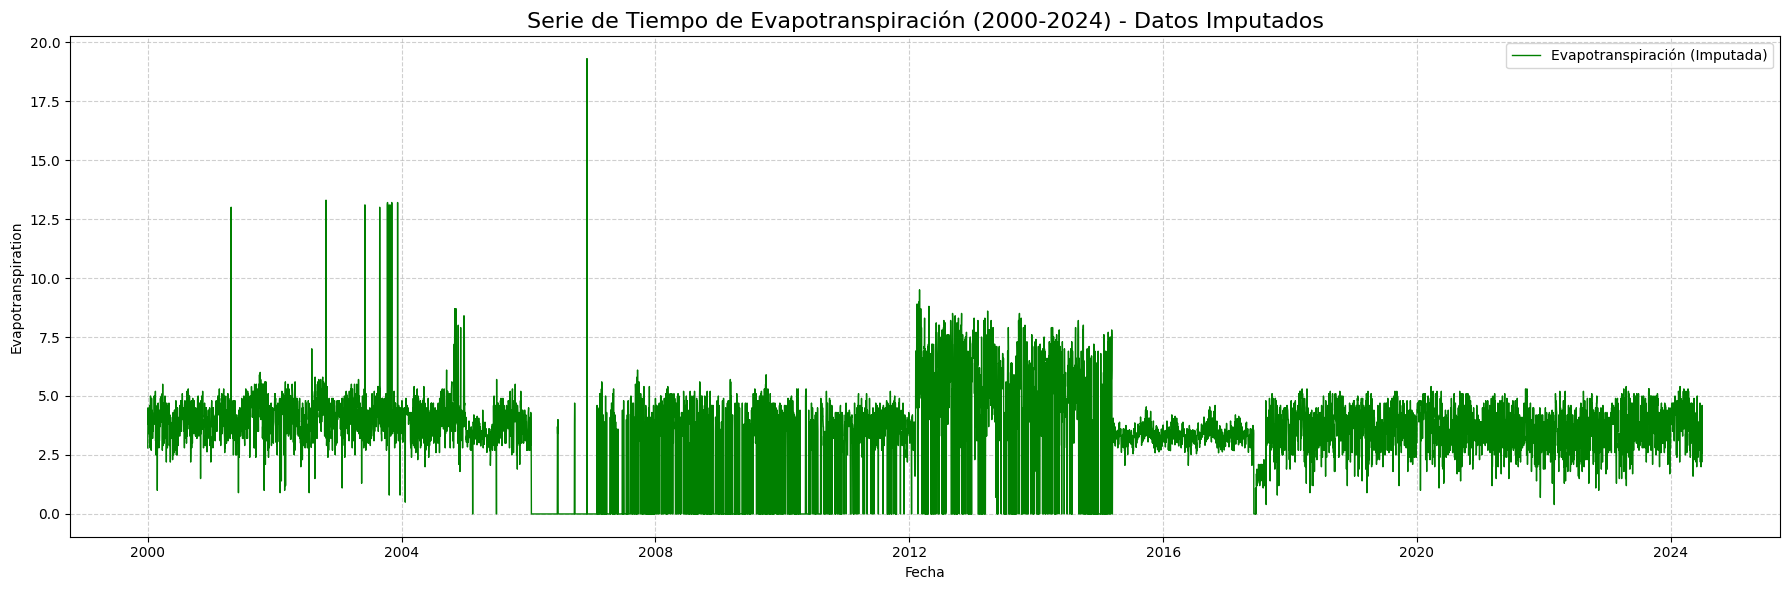


--- Verificación en la Brecha (2015-2018) ---


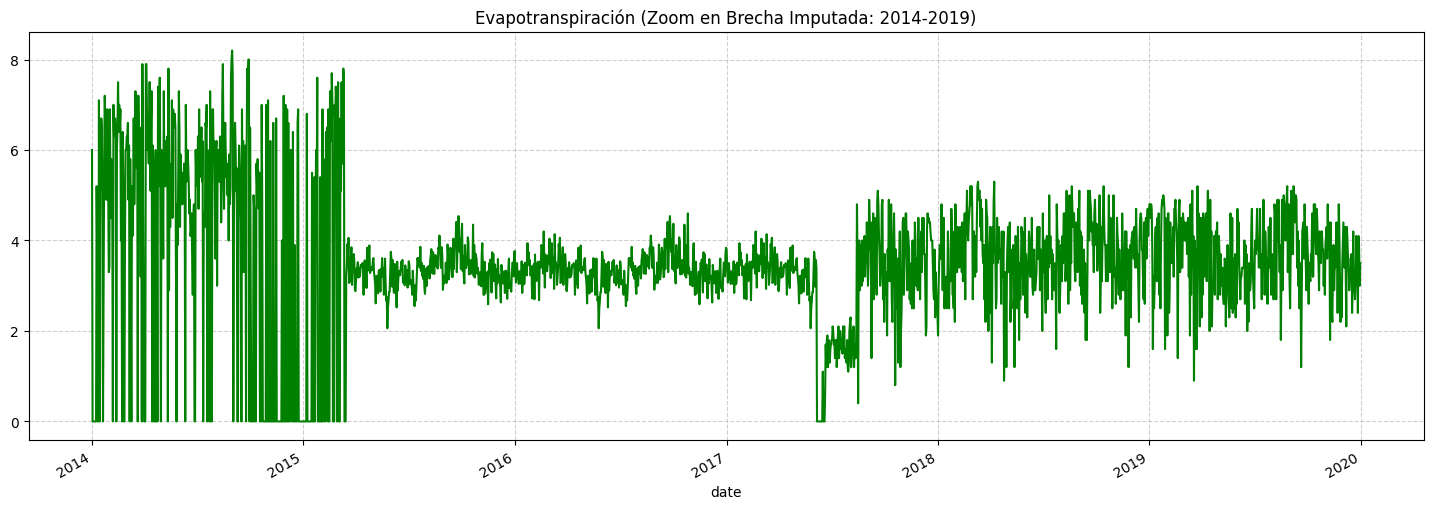

In [ ]:
# 1. Asegurarse de que el índice es de tipo DatetimeIndex (si no lo hizo en pasos anteriores)
if not isinstance(df_imputado.index, pd.DatetimeIndex):
    # Esto es solo una verificación de seguridad si el índice no está configurado
    if 'date' in df_imputado.columns:
        df_imputado = df_imputado.set_index('date')
    df_imputado.index = pd.to_datetime(df_imputado.index)

# 2. Generar el gráfico
plt.figure(figsize=(18, 6))

# Grafica la serie completa. Ahora no habrá saltos ni NaN.
plt.plot(df_imputado.index,
         df_imputado['evapotranspiration'],
         color='green', # Usamos un color distinto para diferenciar de los gráficos originales
         linewidth=1.0,
         label='Evapotranspiración (Imputada)')

# 3. Formato y Título
plt.title("Serie de Tiempo de Evapotranspiración (2000-2024) - Datos Imputados", fontsize=16)
plt.xlabel("Fecha")
plt.ylabel("Evapotranspiration")
plt.legend(loc='upper right')
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

# 4. (Opcional) Zoom para verificar la imputación en la zona 2015-2018
print("\n--- Verificación en la Brecha (2015-2018) ---")
plt.figure(figsize=(18, 6))
df_imputado.loc['2014':'2019', 'evapotranspiration'].plot(
    color='green', linewidth=1.5,
    title='Evapotranspiración (Zoom en Brecha Imputada: 2014-2019)'
)
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

kammbio
## Imputación con interpolación para las otras variables con nulos

In [ ]:
# Definir las columnas que contienen los NaN
columnas_a_interpolar = [
    'min_temp', 'avg_temp', 'max_temp', 'min_rel_humidity',
    'avg_rel_humidity', 'max_rel_humidity', 'solar_radiation',
]

# Aplicar la interpolación 'time' a todas las columnas seleccionadas
for columna in columnas_a_interpolar:
    df_imputado[columna] = df_imputado[columna].interpolate(method='time', limit_direction='both')


In [ ]:
df_imputado.loc['2002-04-16':'2002-04-20']

,min_temp,avg_temp,max_temp,min_rel_humidity,avg_rel_humidity,max_rel_humidity,solar_radiation,evapotranspiration,precipitation,year,precipitation_ma21,precipitation_ma7,precipitation_ma14,precipitation_ma30,precipitation_ma5
date,,,,,,,,,,,,,,,
2002-04-16,20.00,24.20,31.2,47.0,80.00,100.0,452.0,4.90,0.0,2002,5.047619,0.814286,5.357143,4.933333,1.14
2002-04-17,19.95,23.95,30.5,48.0,81.25,100.0,436.0,3.56,0.0,2002,3.700000,0.814286,5.357143,4.933333,1.14
2002-04-18,19.90,23.70,29.8,49.0,82.50,100.0,420.0,3.04,0.0,2002,3.595238,0.814286,5.357143,4.933333,1.14
2002-04-19,19.85,23.45,29.1,50.0,83.75,100.0,404.0,3.48,0.0,2002,3.595238,0.814286,5.314286,4.933333,1.10
2002-04-20,19.80,23.20,28.4,51.0,85.00,100.0,388.0,4.10,7.2,2002,3.938095,1.842857,5.828571,4.493333,1.44


## Imputando todos los nulos con interpolacion

In [ ]:
df_imp1=df.copy()
df_imp1= df_imp1.set_index('date')
df_imp1.index = pd.to_datetime(df_imp1.index)

In [ ]:
#Definir un umbral superior basado en el conocimiento del dominio.
# Si 6999 es claramente un error, podemos usar un umbral conservador (e.g., 20)
UMBRAL_SUPERIOR = 20

# Reemplazar el valor atípico (outlier) con NaN
# Esto es esencial antes de la imputación estacional
df_imp1.loc[df_imp1['evapotranspiration'] > UMBRAL_SUPERIOR, 'evapotranspiration'] = None # Usamos 'None' o np.nan

print(f"Valores de evapotranspiration > {UMBRAL_SUPERIOR} han sido convertidos a NaN.")

Valores de evapotranspiration > 20 han sido convertidos a NaN.


In [ ]:
# Definir las columnas que contienen los NaN
columnas_a_interpolar = [
    'min_temp', 'avg_temp', 'max_temp', 'min_rel_humidity',
    'avg_rel_humidity', 'max_rel_humidity', 'solar_radiation', 'evapotranspiration'
]

# Aplicar la interpolación 'time' a todas las columnas seleccionadas
for columna in columnas_a_interpolar:
    df_imp1[columna] = df_imp1[columna].interpolate(method='time', limit_direction='both')


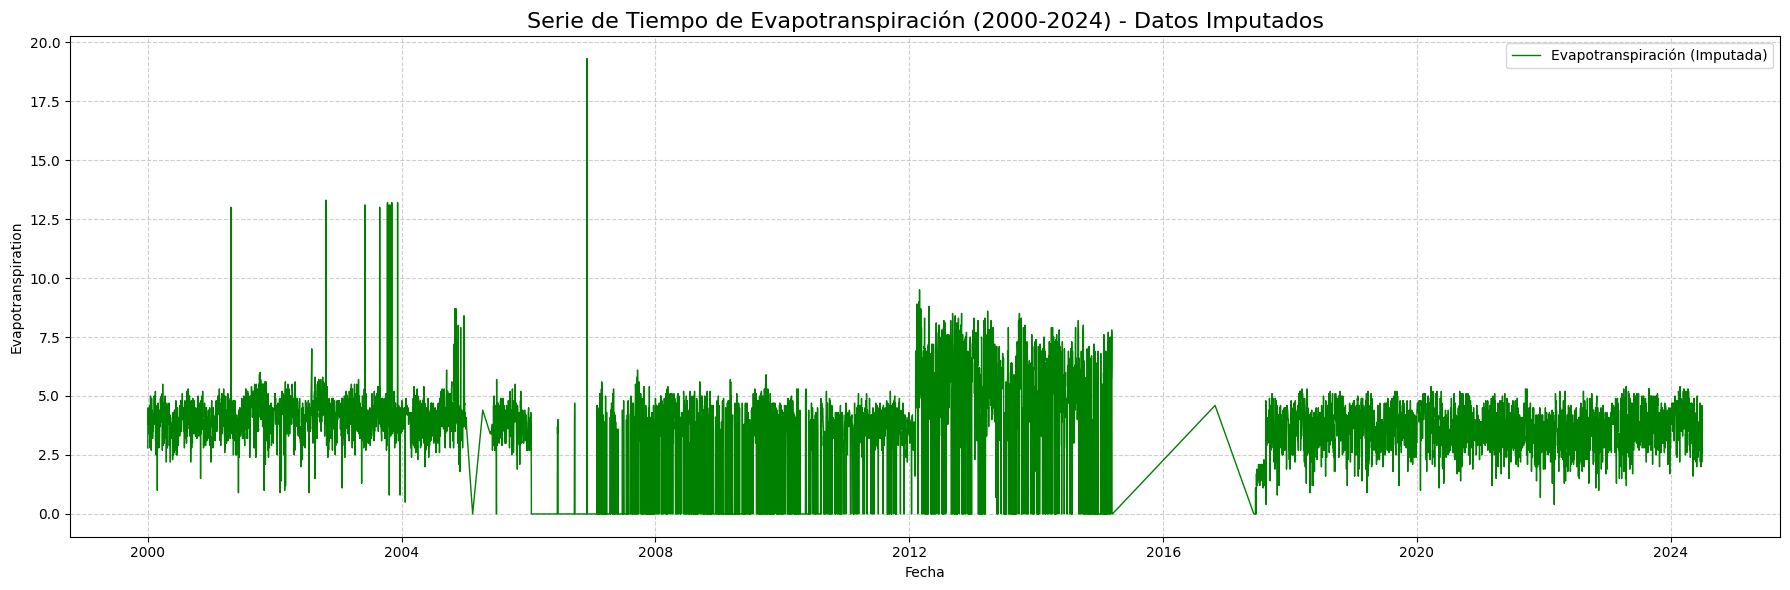


--- Verificación en la Brecha (2015-2018) ---


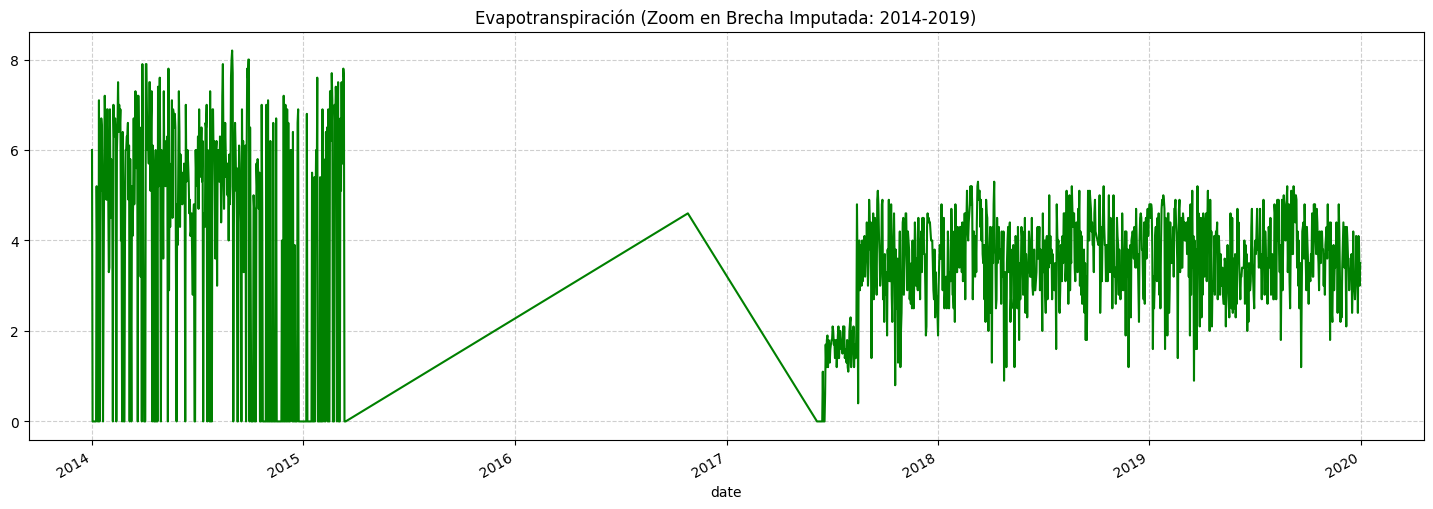

In [ ]:
# 1. Asegurarse de que el índice es de tipo DatetimeIndex (si no lo hizo en pasos anteriores)
if not isinstance(df_imp1.index, pd.DatetimeIndex):
    # Esto es solo una verificación de seguridad si el índice no está configurado
    if 'date' in df_imp1.columns:
        df_imp1= df_imp1.set_index('date')
    df_imp1.index = pd.to_datetime(df_imp1.index)

# 2. Generar el gráfico
plt.figure(figsize=(18, 6))

# Grafica la serie completa. Ahora no habrá saltos ni NaN.
plt.plot(df_imp1.index,
         df_imp1['evapotranspiration'],
         color='green', # Usamos un color distinto para diferenciar de los gráficos originales
         linewidth=1.0,
         label='Evapotranspiración (Imputada)')

# 3. Formato y Título
plt.title("Serie de Tiempo de Evapotranspiración (2000-2024) - Datos Imputados", fontsize=16)
plt.xlabel("Fecha")
plt.ylabel("Evapotranspiration")
plt.legend(loc='upper right')
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

# 4. (Opcional) Zoom para verificar la imputación en la zona 2015-2018
print("\n--- Verificación en la Brecha (2015-2018) ---")
plt.figure(figsize=(18, 6))
df_imp1.loc['2014':'2019', 'evapotranspiration'].plot(
    color='green', linewidth=1.5,
    title='Evapotranspiración (Zoom en Brecha Imputada: 2014-2019)'
)
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

In [ ]:
df_imputado.head()

,min_temp,avg_temp,max_temp,min_rel_humidity,avg_rel_humidity,max_rel_humidity,solar_radiation,evapotranspiration,precipitation,year,precipitation_ma21,precipitation_ma7,precipitation_ma14,precipitation_ma30,precipitation_ma5
date,,,,,,,,,,,,,,,
2000-01-01,20.1,23.1,27.5,57.0,77.0,95.0,308.1,2.8,0.0,2000,NaN,NaN,NaN,NaN,NaN
2000-01-02,19.2,22.0,26.7,58.0,82.0,98.0,343.1,4.1,0.0,2000,NaN,NaN,NaN,NaN,NaN
2000-01-03,18.0,21.7,28.8,51.0,80.0,98.0,456.1,4.5,2.1,2000,NaN,NaN,NaN,NaN,NaN
2000-01-04,17.8,21.9,27.1,50.0,74.0,90.0,391.5,3.8,0.0,2000,NaN,NaN,NaN,NaN,NaN
2000-01-05,19.0,22.3,27.4,51.0,76.0,95.0,348.4,3.9,0.0,2000,NaN,NaN,NaN,NaN,0.42


# Seleccionamos imputación combinada:

Media móvila para evapotranspiration, e imputación con interpolación para las demás variables

In [ ]:
df_imputado.tail()

,min_temp,avg_temp,max_temp,min_rel_humidity,avg_rel_humidity,max_rel_humidity,solar_radiation,evapotranspiration,precipitation,year,precipitation_ma21,precipitation_ma7,precipitation_ma14,precipitation_ma30,precipitation_ma5
date,,,,,,,,,,,,,,,
2024-06-26,19.5,23.0,29.1,58.0,87.0,100.0,358.8,2.9,0.0,2024,2.785714,2.328571,3.721429,3.426667,3.12
2024-06-27,20.2,22.0,27.9,66.0,92.0,100.0,276.0,2.2,0.9,2024,2.828571,2.457143,3.614286,3.456667,2.94
2024-06-28,18.8,22.7,28.4,59.0,88.0,100.0,379.5,3.1,1.9,2024,2.919048,2.628571,2.550000,2.890000,1.18
2024-06-29,20.2,24.4,31.0,51.0,81.0,100.0,547.2,4.6,0.0,2024,2.880952,2.371429,1.557143,2.890000,1.08
2024-06-30,19.5,22.8,28.9,59.0,87.0,100.0,324.7,2.6,0.0,2024,2.814286,0.842857,1.435714,2.890000,0.56


In [ ]:
df_imputado.isnull().sum()

,0
min_temp,0
avg_temp,0
max_temp,0
min_rel_humidity,0
avg_rel_humidity,0
max_rel_humidity,0
solar_radiation,0
evapotranspiration,0
precipitation,0
year,0


kambio: todas las celdas desde aquí hasta donde indique

**ver si eliminamos esto y dejamos los parámetros para definir en el entrenamiento**

# Parámetros

In [ ]:
sequence_length = 5 # kambio validar con 7 y 14 especialmente para RNN/LSTM - La precipitación tiene memoria temporal corta, tiene un comportamiento aleatorio
TARGET_COLUMN = 'precipitation'

# División temporal (train/val)

In [ ]:
# Contar registros por año
counts_per_year = df_imputado.groupby(df_imputado.index.year).size()
print("Registros por año:")
print(counts_per_year)

cumsum_per_year= counts_per_year.cumsum()
print("\nAcumulado por año:")
print(cumsum_per_year)

Registros por año:
date
2000    366
2001    365
2002    365
2003    365
2004    359
2005    362
2006    365
2007    365
2008    363
2009    365
2010    363
2011    365
2012    366
2013    365
2014    364
2015    365
2016    366
2017    365
2018    365
2019    365
2020    366
2021    365
2022    365
2023    365
2024    182
dtype: int64

Acumulado por año:
date
2000     366
2001     731
2002    1096
2003    1461
2004    1820
2005    2182
2006    2547
2007    2912
2008    3275
2009    3640
2010    4003
2011    4368
2012    4734
2013    5099
2014    5463
2015    5828
2016    6194
2017    6559
2018    6924
2019    7289
2020    7655
2021    8020
2022    8385
2023    8750
2024    8932
dtype: int64


In [ ]:
# Contar, y mostrar los registros de años bisiestos, con menos de 366 registros

years_to_check = [2000, 2004, 2008, 2012, 2016, 2020, 2024]
filtered_counts = counts_per_year[(counts_per_year < 366) & (counts_per_year.index.isin(years_to_check))]

print("Registros por año (menos de 366 días) para los años bisiestos:")
print(filtered_counts)

Registros por año (menos de 366 días) para los años bisiestos:
date
2004    359
2008    363
2024    182
dtype: int64


In [ ]:
# Cuenta de los registros de los años que tuvieron 365 días y tienen menos de 365 registros
non_leap_years = [year for year in counts_per_year.index if year not in [2000, 2004, 2008, 2012, 2016, 2020, 2024]]
filtered_counts_non_leap = counts_per_year[(counts_per_year < 365) & (counts_per_year.index.isin(non_leap_years))]

print("Registros por año (menos de 365 días) para los años no bisiestos:")
print(filtered_counts_non_leap)

Registros por año (menos de 365 días) para los años no bisiestos:
date
2005    362
2010    363
2014    364
dtype: int64


El año con mucho menos registros que los demás es 2024, que tiene 182 porque son registros hasta el mes de junio

Entre 2000 y 2025, los años bisiestos (con 366 días) fueron:
2000, 2004, 2008, 2012, 2016, 2020, 2024. Sin embargo 2004 y 2008 tienen menos pero la diferencia no parece significativa, al igual que los años de 365 días que tienen menos de esta canntidad de registros

In [ ]:
# Convertir a porcentaje
cumsum_perc = (cumsum_per_year / cumsum_per_year.iloc[-1]) * 100

# Mostrar porcentaje de acumulado
print(cumsum_perc)

date
2000      4.097627
2001      8.184057
2002     12.270488
2003     16.356919
2004     20.376176
2005     24.429019
2006     28.515450
2007     32.601881
2008     36.665920
2009     40.752351
2010     44.816391
2011     48.902821
2012     53.000448
2013     57.086879
2014     61.162114
2015     65.248545
2016     69.346171
2017     73.432602
2018     77.519033
2019     81.605464
2020     85.703090
2021     89.789521
2022     93.875952
2023     97.962382
2024    100.000000
dtype: float64


In [ ]:
# Usamos los datos del año 2024 para validación, y los anteriores para entrenamiento
train_df = df_imputado[df_imputado.year <= 2023].copy()
val_df = df_imputado[df_imputado.year >= 2024].copy()

In [ ]:
train_df

,min_temp,avg_temp,max_temp,min_rel_humidity,avg_rel_humidity,max_rel_humidity,solar_radiation,evapotranspiration,precipitation,year,precipitation_ma21,precipitation_ma7,precipitation_ma14,precipitation_ma30,precipitation_ma5
date,,,,,,,,,,,,,,,
2000-01-01,20.1,23.1,27.5,57.0,77.0,95.0,308.1,2.8,0.0,2000,NaN,NaN,NaN,NaN,NaN
2000-01-02,19.2,22.0,26.7,58.0,82.0,98.0,343.1,4.1,0.0,2000,NaN,NaN,NaN,NaN,NaN
2000-01-03,18.0,21.7,28.8,51.0,80.0,98.0,456.1,4.5,2.1,2000,NaN,NaN,NaN,NaN,NaN
2000-01-04,17.8,21.9,27.1,50.0,74.0,90.0,391.5,3.8,0.0,2000,NaN,NaN,NaN,NaN,NaN
2000-01-05,19.0,22.3,27.4,51.0,76.0,95.0,348.4,3.9,0.0,2000,NaN,NaN,NaN,NaN,0.42
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-27,18.1,23.4,30.8,54.0,84.0,100.0,432.3,3.6,0.0,2023,1.423810,0.642857,2.135714,1.773333,0.90
2023-12-28,19.5,23.0,28.9,61.0,89.0,100.0,358.3,2.9,21.1,2023,2.428571,3.657143,3.585714,2.476667,5.12
2023-12-29,19.5,23.5,29.3,57.0,85.0,100.0,451.6,3.8,0.2,2023,2.438095,3.685714,3.321429,2.483333,5.16


In [ ]:
val_df

,min_temp,avg_temp,max_temp,min_rel_humidity,avg_rel_humidity,max_rel_humidity,solar_radiation,evapotranspiration,precipitation,year,precipitation_ma21,precipitation_ma7,precipitation_ma14,precipitation_ma30,precipitation_ma5
date,,,,,,,,,,,,,,,
2024-01-01,20.9,24.6,30.8,55.0,83.0,100.0,480.5,4.1,0.0,2024,2.633333,3.957143,2.992857,2.620000,5.08
2024-01-02,21.6,24.8,30.3,53.0,82.0,100.0,446.1,3.8,0.0,2024,2.633333,3.628571,2.157143,2.620000,0.86
2024-01-03,19.7,25.0,32.0,48.0,80.0,100.0,532.9,4.5,0.0,2024,2.633333,3.628571,2.135714,2.620000,0.82
2024-01-04,20.2,24.8,31.5,50.0,81.0,100.0,492.3,4.1,0.0,2024,2.595238,0.614286,2.135714,1.843333,0.02
2024-01-05,18.8,24.2,31.1,46.0,80.0,100.0,504.7,4.2,0.0,2024,2.409524,0.585714,2.135714,1.843333,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-06-26,19.5,23.0,29.1,58.0,87.0,100.0,358.8,2.9,0.0,2024,2.785714,2.328571,3.721429,3.426667,3.12
2024-06-27,20.2,22.0,27.9,66.0,92.0,100.0,276.0,2.2,0.9,2024,2.828571,2.457143,3.614286,3.456667,2.94
2024-06-28,18.8,22.7,28.4,59.0,88.0,100.0,379.5,3.1,1.9,2024,2.919048,2.628571,2.550000,2.890000,1.18


In [ ]:
print(train_df.columns)

Index(['min_temp', 'avg_temp', 'max_temp', 'min_rel_humidity',
       'avg_rel_humidity', 'max_rel_humidity', 'solar_radiation',
       'evapotranspiration', 'precipitation', 'year', 'precipitation_ma21',
       'precipitation_ma7', 'precipitation_ma14', 'precipitation_ma30',
       'precipitation_ma5'],
      dtype='object')


## features_cols: Selección de features

**Altera train si seleccionamos precipitation_ma5 ma7 o ma14**

In [ ]:
# Variamos la selección de features, para ver con cuáles tiene mejor rendimiento cada modelo

'''
Iniciamos con las identificadas en el análisis exploratorio:

Según la matriz de correlaciones, existe relación moderada entre precipitación y medias móviles de precipitación de 5 días y 7 días (correlación de 0.5 y 0.42 respectivamente),
una relación débil con el promedio de humedad relativa (0.36) y con el promedio de temperatura (-0.37)

Según nel análisis de las gráficas de las series, las varibles con relación más fuerte son: radiación solar, evapotranspiración y humedad relativa mínima
'''

features_cols = [
    'avg_rel_humidity',
    'avg_temp',
    'evapotranspiration',
    #'max_rel_humidity',
    #'max_temp',
    'min_rel_humidity',
    #'min_temp',
    'solar_radiation',
    #'precipitation_ma7',  # probar después # ventana de 7
    'precipitation_ma5', # ventana de 5
    #'precipitation_ma14' # ventana de 14
]

**Omitir si NO seleccionamos precipitation_ma5 ma7 o ma14**

In [ ]:
# Revisamos nulos en columnas de promedio móvil selecciondas

#print("Null values in precipitation_ma7:", train_df['precipitation_ma7'].isnull().sum())
print("Null values in precipitation_ma5:", train_df['precipitation_ma5'].isnull().sum())
#print("Null values in precipitation_ma:14", train_df['precipitation_ma14'].isnull().sum())

Null values in precipitation_ma5: 4


**Omitir si NO seleccionamos precipitation_ma5 ma7 o ma14**

In [ ]:
# Eliminar las filas donde las columnas de promedio móvil tienen nulos

max_window = 5  # ventana más grande de las columnas de promedio móvil

# Eliminar primeras filas con NaN en las medias móviles
train_df = train_df.iloc[max_window-1:].copy()

# Verificar que no quedan nulos en el conjunto de entrenamiento
print(train_df[features_cols].isnull().sum())

avg_rel_humidity      0
avg_temp              0
evapotranspiration    0
min_rel_humidity      0
solar_radiation       0
precipitation_ma5     0
dtype: int64


## Train y val inicial

In [ ]:
# Eliminamos las columnas que no vamos a usar, tanto del conjunto de entrenamiento como del conjunto de validación
# las que estén comentadas en features_cols
# conservamos precipitación y year

cols_to_drop = ["max_rel_humidity", "max_temp", "min_temp", "precipitation_ma21", "precipitation_ma14", "precipitation_ma30", "precipitation_ma7"]

# Eliminar de train y val
train_df = train_df.drop(columns=cols_to_drop, errors="ignore")
val_df   = val_df.drop(columns=cols_to_drop, errors="ignore")

In [ ]:
print(train_df.columns)
print(train_df.shape)

Index(['avg_temp', 'min_rel_humidity', 'avg_rel_humidity', 'solar_radiation',
       'evapotranspiration', 'precipitation', 'year', 'precipitation_ma5'],
      dtype='object')
(8746, 8)


In [ ]:
print(val_df.columns)
print(val_df.shape)

Index(['avg_temp', 'min_rel_humidity', 'avg_rel_humidity', 'solar_radiation',
       'evapotranspiration', 'precipitation', 'year', 'precipitation_ma5'],
      dtype='object')
(182, 8)


**Registros de los conjuntos de datos:**

| Conjunto    | Registros | Porcentaje | Periodo                 | Duración  |
|--------------|------------|-------------|--------------------------|------------|
| **Train**      | 8,746      | 95.9%       | Ene 2000 – Dic 2023     | 24 años    |
| **Validation** | 182        | 2.0%        | Ene 2024 – Jun 2024     | 6 meses    |
| **Test**       | 184        | 2.0%        | Jul 2024 – Dic 2024     | 6 meses    |
| **Total**      | 9,112      | 100%        | Ene 2000 – Dic 2024     | 24 años 6 meses |


Cobertura estacional complementaria: Val (primer semestre) + Test (segundo semestre) = año completo

**Problema potencial (validar con los resultados de los modelos):**

Solo 182 días (6 meses) puede generar alta variabilidad en métricas

Las decisiones de early stopping pueden ser menos confiables

Si esos 6 meses fueron climáticamente atípicos, las métricas no serán representativas

Revisar si es necesrio ampliar el conjunto de Validación, por ejemplo a 1 año

In [ ]:
# Comparar distribuciones de precipitación
print("Estadísticas de precipitación:")
print(f"Train (2000-2023): {train_df['precipitation'].mean():.2f} mm ± {train_df['precipitation'].std():.2f}") # ACTUALIZAR AÑOS SI SE MODIFICAN LOS CONJUNTOS DE DATOS
print(f"Val (Ene-Jun 2024): {val_df['precipitation'].mean():.2f} mm ± {val_df['precipitation'].std():.2f}")

# Ver días con lluvia
print(f"\nDías con lluvia (>0mm):")
print(f"Train: {(train_df['precipitation'] > 0).sum()} ({(train_df['precipitation'] > 0).mean()*100:.1f}%)")
print(f"Val:   {(val_df['precipitation'] > 0).sum()} ({(val_df['precipitation'] > 0).mean()*100:.1f}%)")


Estadísticas de precipitación:
Train (2000-2023): 3.25 mm ± 8.53
Val (Ene-Jun 2024): 3.20 mm ± 8.34

Días con lluvia (>0mm):
Train: 3885 (44.4%)
Val:   68 (37.4%)


No parece ser una diferencia significativa y puede ser tolerable la variabilidad, aunque la frecuencia de las precipitaciones en validación es menor

Nota: 2024 es climáticamente normal (no hay El Niño/La Niña extremo)

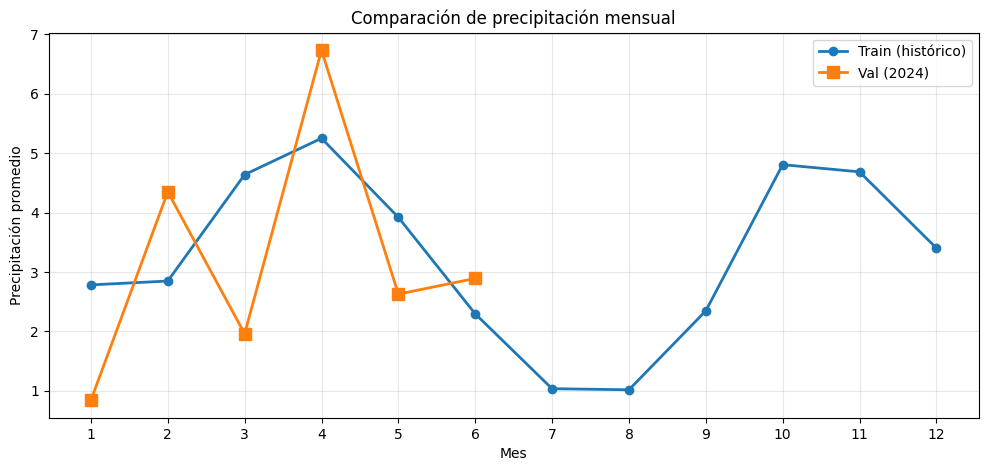

In [ ]:
# Comparar por mes

# Precipitación promedio por mes en Train vs Val/Test
monthly_train = train_df.groupby(train_df.index.month)['precipitation'].mean()
monthly_val = val_df.groupby(val_df.index.month)['precipitation'].mean()

plt.figure(figsize=(12, 5))
months = range(1, 13)
plt.plot(monthly_train.index, monthly_train.values, 'o-', label='Train (histórico)', linewidth=2)
plt.plot(monthly_val.index, monthly_val.values, 's-', label='Val (2024)', linewidth=2, markersize=8)
plt.xlabel('Mes')
plt.ylabel('Precipitación promedio')
plt.title('Comparación de precipitación mensual')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(months)
plt.show()

Dado que train tiene más años y por lo tanto más datos atípicos es normal la diferencia con val, aunque los promedios generales hayan sido similares. Sin embargo ambos varía entre 0 y 7 y coinciden en el pico más alto en abril, incremento en febrero, y baja en mayo

## Validemos una nueva configuración de train y val
Para el entrenamiento y ajuste de hiperparámetros ignoraremos los primeros 6 meses de 2024. Usaremos 2023 como validación para evaluar el rendimiento, así se valida un año completo para considerar estaciones. Después, al tener los hiperparámetros óptimos, reentrenaremos el modelo con todos los datos disponibles hasta junio 2024 para generar pronósticos de julio a diciembre 2024

In [ ]:
# Volvemos a unir los conjuntos de datos, para conservar los cambios que se hayan hecho en train (según variables seleccionadas)
df_combined = pd.concat([train_df, val_df])

# Redefinir train_df y val_df según los nuevos rangos de años
train_df = df_combined[df_combined.year <= 2022].copy() #  entrenaremos con datos del 2000 al 2022
val_df = df_combined[df_combined.year == 2023].copy() # validaremos con datos del 2023

print("train_df shape:", train_df.shape)
print("val_df shape:", val_df.shape)

train_df shape: (8381, 8)
val_df shape: (365, 8)


In [ ]:
# Comparar distribuciones de precipitación
print("Estadísticas de precipitación:")
print(f"Train (2000-2022): {train_df['precipitation'].mean():.2f} mm ± {train_df['precipitation'].std():.2f}") # ACTUALIZAR AÑOS SI SE MODIFICAN LOS CONJUNTOS DE DATOS
print(f"Val (2023): {val_df['precipitation'].mean():.2f} mm ± {val_df['precipitation'].std():.2f}")

# Ver días con lluvia
print(f"\nDías con lluvia (>0mm):")
print(f"Train: {(train_df['precipitation'] > 0).sum()} ({(train_df['precipitation'] > 0).mean()*100:.1f}%)")
print(f"Val:   {(val_df['precipitation'] > 0).sum()} ({(val_df['precipitation'] > 0).mean()*100:.1f}%)")

Estadísticas de precipitación:
Train (2000-2022): 3.23 mm ± 8.48
Val (2023): 3.68 mm ± 9.53

Días con lluvia (>0mm):
Train: 3723 (44.4%)
Val:   162 (44.4%)


Aumentó la media y la desviación, pero la proporción de lluvia/precipitación>0 está vez es igual en val y en train

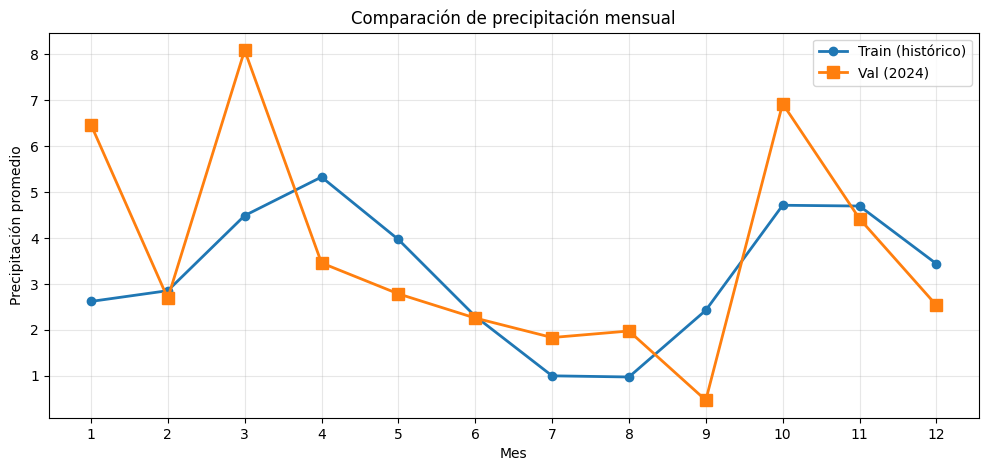

In [ ]:
# Comparar por mes

# Precipitación promedio por mes en Train vs Val/Test
monthly_train = train_df.groupby(train_df.index.month)['precipitation'].mean()
monthly_val = val_df.groupby(val_df.index.month)['precipitation'].mean()

plt.figure(figsize=(12, 5))
months = range(1, 13)
plt.plot(monthly_train.index, monthly_train.values, 'o-', label='Train (histórico)', linewidth=2)
plt.plot(monthly_val.index, monthly_val.values, 's-', label='Val (2024)', linewidth=2, markersize=8)
plt.xlabel('Mes')
plt.ylabel('Precipitación promedio')
plt.title('Comparación de precipitación mensual')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(months)
plt.show()

Como la proporción de días con lluvia es idéntica (44.4%) tanto en Train como en Val. Aunque el comportamiento general es más similar al histórico que con la configuración anterior, esta es una prueba menos rigurosa para la clasificación y puede afectar la generalización del modelo


**Conclusión:**
Se selecciona la primera configuración, donde el conjunto de validación son los datos de enero a jun de 2024, donde las medias de los conjuntos son más similares, hay menos proporción de lluvias y se presentan extremos que se espera ayuden en el entrenamiento para que el modelo considere también las features y generalice mejor

## Train y Val definitivos

In [ ]:
# Volvemos a definir los conjuntos de datos

df_combined_def = df_combined.copy()

# Redefinir train_df y val_df según rangos de años definitivos
train_df = df_combined_def[df_combined_def.year <= 2023].copy() #  entrenaremos con datos del 2000 al 2022
val_df = df_combined_def[df_combined_def.year >= 2024].copy() # definitivamente validaremos con datos del 2024

print("train_df shape:", train_df.shape)
print("val_df shape:", val_df.shape)

train_df shape: (8746, 8)
val_df shape: (182, 8)


# Homogenización de datos

## Estandarización de los features

**Para predicción de precipitación se opta por homogenizar con Estandarización porque:**

StandarScaler maneja bien la diferenncia entre las distribuciones de las variables (valores positivos, negativos, muy pequeños, muy grandes)

Conserva valores negativos (crucial en temperatura)

Mantiene la estructura de outliers (lluvias extremas son información importante)

Las arquitecturas MLP y RNN/LSTM funcionan mejor con:

Datos centrados en 0 (facilita el paso por funciones de activación)
Gradientes más estables durante backpropagation
Convergencia más rápida

Por otro lado, MinMaxScaler es sensible a outliers y no permite los negativos. Con la Normalización, no se considera la magnitud

In [ ]:
# Estandarización de train_df y val_df
scaler = StandardScaler().fit(train_df[features_cols]) # Calcula (.fit()) la media (μ) y desviación estándar (σ) de cada columna en features_cols usando SOLO los datos de entrenamiento
train_df[features_cols] = scaler.transform(train_df[features_cols]) # Transforma los datos de entrenamiento usando la fórmula: z = (x - μ) / σ, características quedan con media ≈ 0 y desviación estándar ≈ 1
val_df[features_cols] = scaler.transform(val_df[features_cols]) # no se entrena scaler con datos de validación para Evitar Data Leakage

In [ ]:
# guardar el scaler para usarlo después en predicciones:
import joblib
joblib.dump(scaler, 'scaler.pkl')

'''
# Para usar después:
scaler = joblib.load('scaler.pkl')
new_data_scaled = scaler.transform(new_data)
'''

"\n# Para usar después:\nscaler = joblib.load('scaler.pkl')\nnew_data_scaled = scaler.transform(new_data)\n"

In [ ]:
train_df

,avg_temp,min_rel_humidity,avg_rel_humidity,solar_radiation,evapotranspiration,precipitation,year,precipitation_ma5
date,,,,,,,,
2000-01-05,-0.876640,0.131776,-0.558128,-0.484518,0.302948,0.0,2000,-0.649843
2000-01-06,-1.147115,0.238876,-0.273464,-0.492870,0.356609,0.0,2000,-0.649843
2000-01-07,-2.860120,2.380889,1.149854,-1.416758,0.034646,4.1,2000,-0.461433
2000-01-08,-2.409329,0.667279,0.580527,-0.357157,0.141967,1.8,2000,-0.475219
2000-01-09,-1.237273,-0.082426,-0.131133,-0.103480,0.088306,0.0,2000,-0.475219
...,...,...,...,...,...,...,...,...
2023-12-27,0.115100,0.453078,0.580527,0.391348,0.141967,0.0,2023,-0.539554
2023-12-28,-0.245533,1.202782,1.292186,-0.381168,-0.233657,21.1,2023,0.430065
2023-12-29,0.205258,0.774380,0.722858,0.592829,0.249288,0.2,2023,0.439256


In [ ]:
val_df

,avg_temp,min_rel_humidity,avg_rel_humidity,solar_radiation,evapotranspiration,precipitation,year,precipitation_ma5
date,,,,,,,,
2024-01-01,1.196998,0.560178,0.438195,0.894528,0.410269,0.0,2024,0.420875
2024-01-02,1.377314,0.345977,0.295863,0.535412,0.249288,0.0,2024,-0.548745
2024-01-03,1.557630,-0.189526,0.011199,1.441553,0.624912,0.0,2024,-0.557936
2024-01-04,1.377314,0.024675,0.153531,1.017713,0.410269,0.0,2024,-0.741750
2024-01-05,0.836365,-0.403728,0.011199,1.147162,0.463930,0.0,2024,-0.746345
...,...,...,...,...,...,...,...,...
2024-06-26,-0.245533,0.881480,1.007522,-0.375948,-0.233657,0.0,2024,-0.029470
2024-06-27,-1.147115,1.738285,1.719181,-1.240332,-0.609281,0.9,2024,-0.070828
2024-06-28,-0.516008,0.988581,1.149854,-0.159853,-0.126336,1.9,2024,-0.475219


## Escalamiento de los features

In [ ]:
'''
from sklearn.preprocessing import MinMaxScaler
# Inicializar el MinMaxScaler
scaler = MinMaxScaler().fit(train_df[features_cols])

# Transformar train, val con el mismo fit
train_df[features_cols] = scaler.transform(train_df[features_cols])
val_df[features_cols]   = scaler.transform(val_df[features_cols])
'''

## Normalización de features

In [ ]:
'''
from sklearn.preprocessing import Normalizer
normalizer = Normalizer().fit(train_df[features_cols])

# Aplicar la transformación usando el mismo fit
train_df[features_cols] = normalizer.transform(train_df[features_cols])
val_df[features_cols]   = normalizer.transform(val_df[features_cols])
'''

**Importante:**
**La estandarización** transforma cada variable para que tenga media 0 y desviación estándar 1, conservando la forma de la distribución.
**El escalamiento** ajusta los valores de cada variable a un rango específico, por ejemplo
[
0
,
1
]
[0,1] con MinMaxScaler, sin cambiar la forma de la distribución. **La normalización** consiste en tomar cada fila de datos y “ajustarla” para que todos sus valores juntos tengan la misma escala. Es como si transformaras cada fila en un vector cuya longitud es 1, manteniendo la proporción entre sus valores.

Es necesario en estos procesos, tener en cuenta que existen estas técnicas para el posterior modelamiento

In [ ]:
# Nota: tanto train_df como val_df están limpios, sin nulos
val_df.isnull().sum()

,0
avg_temp,0
min_rel_humidity,0
avg_rel_humidity,0
solar_radiation,0
evapotranspiration,0
precipitation,0
year,0
precipitation_ma5,0


In [ ]:
train_df.isnull().sum()

,0
avg_temp,0
min_rel_humidity,0
avg_rel_humidity,0
solar_radiation,0
evapotranspiration,0
precipitation,0
year,0
precipitation_ma5,0


# Creando datasets

Clase para crear un Dataset personalizado de PyTorch para entrenar un modelo MLP con series temporales

Convierte un DataFrame de series temporales en pares (X, y) donde:

X: Ventana de datos históricos (aplanada en un vector)
y: Valor objetivo a predecir en el futuro

**Nota: en val:df tenemos 182 registros y el df_test tenemos 184**

In [ ]:
# ==== 2) Dataset que entrega ventanas aplanadas (MLP) con (X, y) ====

'''
Parámetros:
df: DataFrame con datos de series temporales
sequence_length: Ventana temporal (ej: 5 días hacia atrás del objetivo a predecir) # ya definida antes (5), ver Parámetros
features_cols: Lista de columnas a usar como features - ya defnidia ver: Selección de features: puede alterar train si seleccionamos precipitation_ma5 ma7 o ma14
TARGET_COLUMN: Columna objetivo ('precipitation') # ya definida antes, ver Parámetros
is_train: Si es entrenamiento o validación (no se usa en el código)
horizon: Cuántos pasos hacia adelante predecir (default=1, predice el siguiente día)
'''

class PrecipitationDataset(Dataset):
    def __init__(self, df, sequence_length, features_cols, TARGET_COLUMN, is_train=True, horizon=1): # validar return_mode="sequence"
        self.seq_len = sequence_length
        self.features_cols = list(features_cols)
        self.TARGET_COLUMN = TARGET_COLUMN
        self.h = horizon # cuántos días adelante predigo con cada ventana, si horizon = 7 predice y de una semana después de la última observación.
        self.data = [] # lista vacía donde se almacenarán los pares (X, y)

        g = df.reset_index(drop=True) # Resetea el índice del DataFrame para trabajar con índices numéricos consecutivos
        n = len(g) # número de filas del DataFrame

        # Calcula cuántas ventanas válidas se pueden crear
        # Si n=100, seq_len=5, horizon=1: max_i = 100 - 5 - 0 = 95 ventanas
        # Si no hay suficientes datos, sale sin crear ventanas
        max_i = n - self.seq_len - (self.h - 1)
        if max_i <= 0:
            return



        # Extrae ventana de features:
        # .values: Convierte a numpy array
        # Forma: (sequence_length, num_features)
        for i in range(max_i):
            X = g.iloc[i : i + self.seq_len][self.features_cols].values  # (W, F): shape: self.seq_len, Features - g.iloc[i : i + self.seq_len] toma filas del Dataframe desde i hasta ((i + self.seq_len) - 1) iloc no incluye el dato final del rango, perosí el primero

            # Convierte matriz 2D en vector 1D, Ejemplo: (5, 10) → (50,)
            X = X.reshape(-1)  # aplanado para MLP

            # Extrae el valor objetivo justo después de la ventana de entrada
            # + (h - 1): Ajusta para horizonte (si h=1, es 0, predice día siguiente inmediato)
            # Ejemplo: Si seq_len= 5, par la ventana 0, que son los días 0 a 4, entonces y es el día 5
            y = g.iloc[i + self.seq_len + (self.h - 1)][self.TARGET_COLUMN]

            # Guarda el par (ventana_aplanada, objetivo) en la lista
            self.data.append((X, y))

    # Retornar el Tamaño del dataset
    def __len__(self):
        return len(self.data)

    # Obtener un ejemplo (entrada, objetivo)
    def __getitem__(self, idx):
        X, y = self.data[idx]
        X = torch.tensor(X, dtype=torch.float32)
        y = torch.tensor(y, dtype=torch.float32)
        return X, y

In [ ]:
# ==== 3) Crear datasets
sequence_length = sequence_length
train_dataset = PrecipitationDataset(train_df, sequence_length, features_cols, TARGET_COLUMN, horizon=1)
val_dataset   = PrecipitationDataset(val_df,   sequence_length, features_cols, TARGET_COLUMN, horizon=1)

# Creando dataloaders
DataLoader de PyTorch toma el dataset y lo divide en lotes (batches) para alimentar el modelo durante el entrenamiento.

Transforma una lista completa de muestras (X, y) en pequeños paquetes (batches) que el modelo procesa en cada paso.

In [ ]:
# ==== 4) DataLoaders (ahora sí) ====
BATCH_SIZE = 32 # 16, 32, 64
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True) # Mezcla las muestras al inicio de cada época, para evitar que el modelo aprenda patrones del orden temporal en los datos de entrenamiento.
val_loader   = DataLoader(val_dataset,   batch_size=BATCH_SIZE, shuffle=False) # En validación se mantiene el orden, así se compara los resultados en el mismo orden temporal.

print(f"Número de batches en train_loader: {len(train_loader)}")
print(f"Número de batches en val_loader:   {len(val_loader)}")

Número de batches en train_loader: 274
Número de batches en val_loader:   6


In [ ]:
# Obtener el primer batch del DataLoader
X_batch, y_batch = next(iter(train_loader))

print("Forma de X_batch:", X_batch.shape) # X_batch.shape → (batch_size, input_size)
print("Forma de y_batch:", y_batch.shape)


# si sequence_length = 5 y en features_cols tenemos 6 variables entonces input_size= 6*5= 30
# y Si BATCH_SIZE = 32, Cada batch tiene 32 ejemplos (ventanas), y cada ventana representa 30 valores de entrada

Forma de X_batch: torch.Size([32, 30])
Forma de y_batch: torch.Size([32])


# Creando el modelo MLP

Un MLP (Perceptrón Multicapa) es una red neuronal “clásica”, totalmente conectada (fully connected).
Recibe un vector de entrada, lo pasa por una o más capas ocultas con funciones de activación (como ReLU), y produce una salida (en este caso, la precipitación pronosticada).

In [ ]:
# ==== 5) Modelo MLP
class SimpleMLP(nn.Module):
    def __init__(self, input_size, hidden_size=64): # hidden_size: número de neuronas en la capa oculta (por defecto 64, pero probar 32, 128, etc.).
        super(SimpleMLP, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 1)
        )
    def forward(self, x):
        return self.fc(x).squeeze(-1)  # <- evita problemas con batch=1

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_size = len(features_cols) * sequence_length
model = SimpleMLP(input_size).to(device)

# Entrenamiento

In [ ]:
# ==== 6) Entrenamiento con loaders ====
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3) # Este hiperparametro pueden ensayarlo con otros valores

for epoch in range(20):
    # --- Train ---
    model.train()
    train_loss = 0.0
    for x_batch, y_batch in train_loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)

        # sanity check: sin NaN
        if torch.isnan(x_batch).any() or torch.isnan(y_batch).any():
            raise ValueError("Hay NaN en x_batch o y_batch (train)")

        optimizer.zero_grad()
        preds = model(x_batch)
        loss = criterion(preds, y_batch)
        if torch.isnan(loss):
            raise ValueError("Loss NaN en train; revisa datos/targets.")
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    # --- Val ---
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for x_batch, y_batch in val_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)

            if torch.isnan(x_batch).any() or torch.isnan(y_batch).any():
                raise ValueError("Hay NaN en x_batch o y_batch (val)")

            preds = model(x_batch)
            loss = criterion(preds, y_batch)
            if torch.isnan(loss):
                raise ValueError("Loss NaN en val; revisa datos/targets.")
            val_loss += loss.item()

    print(f"Epoch {epoch+1}/20 | Train MSE: {train_loss/len(train_loader):.4f} | Val MSE: {val_loss/len(val_loader):.4f}")

Epoch 1/20 | Train MSE: 74.7047 | Val MSE: 69.2941
Epoch 2/20 | Train MSE: 71.3129 | Val MSE: 68.6167
Epoch 3/20 | Train MSE: 70.4024 | Val MSE: 67.8102
Epoch 4/20 | Train MSE: 70.0279 | Val MSE: 67.8528
Epoch 5/20 | Train MSE: 69.7945 | Val MSE: 67.3574
Epoch 6/20 | Train MSE: 69.6463 | Val MSE: 65.9870
Epoch 7/20 | Train MSE: 69.3807 | Val MSE: 65.4098
Epoch 8/20 | Train MSE: 69.2857 | Val MSE: 65.6652
Epoch 9/20 | Train MSE: 69.3000 | Val MSE: 64.7898
Epoch 10/20 | Train MSE: 68.9579 | Val MSE: 65.3795
Epoch 11/20 | Train MSE: 69.2041 | Val MSE: 64.9995
Epoch 12/20 | Train MSE: 68.7696 | Val MSE: 65.2682
Epoch 13/20 | Train MSE: 68.7160 | Val MSE: 65.3279
Epoch 14/20 | Train MSE: 68.5240 | Val MSE: 64.4455
Epoch 15/20 | Train MSE: 68.4744 | Val MSE: 65.0590
Epoch 16/20 | Train MSE: 68.4058 | Val MSE: 64.4752
Epoch 17/20 | Train MSE: 68.2636 | Val MSE: 65.3461
Epoch 18/20 | Train MSE: 68.2049 | Val MSE: 64.4597
Epoch 19/20 | Train MSE: 68.1745 | Val MSE: 63.9641
Epoch 20/20 | Train M

# Guardando el modelo entrenado con train y validado con val

In [ ]:
torch.save(model.state_dict(), 'preciítation_model.pth')

# Reentrenamiento del modelo final con todo el dataset

In [ ]:
# --- 1) Unificar train + val y ordenar temporalmente ---
# Si existe GROUP_COLUMN en los dataframes, se ordena por grupo y fecha; si no, solo por fecha.
def build_full_train(train_df, val_df):
    full = pd.concat([train_df, val_df], ignore_index=True)
    # columnas de ordenamiento
    sort_cols = []
    if 'GROUP_COLUMN' in globals() and GROUP_COLUMN in full.columns:
        sort_cols.append(GROUP_COLUMN)
    # usa 'anio' y 'semana' si existen; en tu caso suele existir 'date'
    if 'anio' in full.columns:   sort_cols.append('anio')
    if 'semana' in full.columns: sort_cols.append('semana')
    if 'date' in full.columns and 'anio' not in full.columns:
        sort_cols.append('date')

    if sort_cols:
        full = full.sort_values(by=sort_cols).reset_index(drop=True)
    else:
        full = full.sort_values(by=full.columns.tolist()).reset_index(drop=True)
    return full

full_train_df = build_full_train(train_df, val_df)

# --- 2) (Importante) No volver a hacer .fit() ---
# Usa el mismo transformador que ya tengas (scaler o normalizer). No re-ajustes para evitar leakage.
# Intentamos aplicar 'scaler' si existe; si no, 'normalizer'. Omite si no quieres transformar.
if 'scaler' in globals() and scaler is not None:
    full_train_df[features_cols] = scaler.transform(full_train_df[features_cols])
elif 'normalizer' in globals() and normalizer is not None:
    full_train_df[features_cols] = normalizer.transform(full_train_df[features_cols])
# Si no quieres ninguna transformación, comenta el bloque anterior.

# (Opcional pero recomendado) Limpiar inf/NaN por si quedaron al unir
full_train_df = full_train_df.replace([np.inf, -np.inf], np.nan).dropna(subset=features_cols + [TARGET_COLUMN])

# --- 3) Crear dataset y dataloader (usa tu clase PrecipitationDataset) ---
sequence_length = sequence_length  # ya definido por ti
BATCH_SIZE = 32

# Para MLP (entrada aplanada):
full_dataset = PrecipitationDataset(
    full_train_df,
    sequence_length=sequence_length,
    features_cols=features_cols,
    TARGET_COLUMN=TARGET_COLUMN,
    is_train=True,
    #return_mode="flat",   # "sequence" si vas a usar RNN/LSTM/GRU/TCN
    horizon=1
)

full_loader = DataLoader(full_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [ ]:
# 4. Reinicializar modelo (si quieres entrenar desde cero)
model = SimpleMLP(input_size).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 5. Entrenar con todo el dataset
print("\n🔁 Reentrenando con todo el dataset (train + val)...\n")
for epoch in range(20):
    model.train()
    train_loss = 0
    for x_batch, y_batch in full_loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        loss = criterion(model(x_batch), y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    print(f"[FINAL] Epoch {epoch+1}/20 | Train MSE: {train_loss / len(full_loader):.4f}")


🔁 Reentrenando con todo el dataset (train + val)...

[FINAL] Epoch 1/20 | Train MSE: 71.1037
[FINAL] Epoch 2/20 | Train MSE: 67.7566
[FINAL] Epoch 3/20 | Train MSE: 65.4900
[FINAL] Epoch 4/20 | Train MSE: 63.6033
[FINAL] Epoch 5/20 | Train MSE: 63.6244
[FINAL] Epoch 6/20 | Train MSE: 63.2374
[FINAL] Epoch 7/20 | Train MSE: 62.8026
[FINAL] Epoch 8/20 | Train MSE: 62.4076
[FINAL] Epoch 9/20 | Train MSE: 63.2020
[FINAL] Epoch 10/20 | Train MSE: 63.2000
[FINAL] Epoch 11/20 | Train MSE: 62.2744
[FINAL] Epoch 12/20 | Train MSE: 62.2518
[FINAL] Epoch 13/20 | Train MSE: 61.8437
[FINAL] Epoch 14/20 | Train MSE: 62.2622
[FINAL] Epoch 15/20 | Train MSE: 62.3279
[FINAL] Epoch 16/20 | Train MSE: 62.0713
[FINAL] Epoch 17/20 | Train MSE: 62.3312
[FINAL] Epoch 18/20 | Train MSE: 61.7609
[FINAL] Epoch 19/20 | Train MSE: 62.2121
[FINAL] Epoch 20/20 | Train MSE: 61.8089


# Submission

In [ ]:
# --- 1) Cargar test y ordenar ---

'''
df_test = pd.read_parquet('/kaggle/input/fa-ii-2025-ii-pronosticos-nn-rnn-lstm-tcn/df_test.parquet')
df_test['date'] = pd.to_datetime(df_test['date'])
df_test = df_test.sort_values('date').reset_index(drop=True) #Se los dejo por si en otro caso lo consideran necesario
'''

file_path_test = '/content/drive/My Drive/MCD/MCD_FDA_II/TALLER 2_RNN/fa-ii-2025-ii-pronosticos-nn-rnn-lstm-tcn/df_test.parquet'
df_test = pd.read_parquet(file_path_test)
df_test['date'] = pd.to_datetime(df_test['date'])
df_test = df_test.sort_values('date').reset_index(drop=True)


In [ ]:
# Revisando si hay nulos en Test
df_test.isnull().sum()

,0
date,0
min_temp,0
avg_temp,0
max_temp,0
min_rel_humidity,0
avg_rel_humidity,0
max_rel_humidity,0
solar_radiation,0
evapotranspiration,0


In [ ]:
# Revisando si hay valores infinitos en las columnas numéricas de Test
num_cols = df_test.select_dtypes(include=[np.number])
np.isinf(num_cols).sum()

,0
min_temp,0
avg_temp,0
max_temp,0
min_rel_humidity,0
avg_rel_humidity,0
max_rel_humidity,0
solar_radiation,0
evapotranspiration,0


In [ ]:
'''
NOTA: NO HAY VALORES NULOS, NI INIFINITOS EN TEST

# (opcional) limpieza defensiva
df_test = df_test.replace([np.inf, -np.inf], np.nan) # Reemplaza en todo el DataFrame df_test los valores infinitos (positivos o negativos) por valores nulos (NaN).

# Si algún feature tiene NaN, dependerá de tu caso: puedes rellenar o descartar.
# Aquí supongo que no hay NaN en test. Si los hay, considera un fillna sensato.
# df_test[features_cols] = df_test[features_cols].fillna(method='ffill').fillna(method='bfill') # Cuando hay un valor faltante (NaN), este método lo reemplaza con el último valor válido anterior.
'''

In [ ]:
# EN TEST DEBEMOS TENER LAS MISMAS COLUMNAS DEL ENTRENAMIENTO
# aquí falta precipitation_ma5
features_cols

['avg_rel_humidity',
 'avg_temp',
 'evapotranspiration',
 'min_rel_humidity',
 'solar_radiation',
 'precipitation_ma5']

# Asegurar que Test tenga las mismas columnas que usamos en Train y Val

In [ ]:
df_test

,date,min_temp,avg_temp,max_temp,min_rel_humidity,avg_rel_humidity,max_rel_humidity,solar_radiation,evapotranspiration
0,2024-07-01,17.4,23.4,31.1,49.0,83.0,100.0,529.7,4.3
1,2024-07-02,20.2,23.7,29.8,61.0,85.0,100.0,396.5,3.3
2,2024-07-03,20.9,23.7,30.1,55.0,86.0,100.0,359.3,3.0
3,2024-07-04,19.5,22.7,28.9,63.0,91.0,100.0,304.8,2.4
4,2024-07-05,18.8,20.8,24.4,76.0,96.0,100.0,241.0,1.9
...,...,...,...,...,...,...,...,...,...
179,2024-12-27,19.5,23.2,30.3,53.0,83.0,100.0,336.2,2.7
180,2024-12-28,19.5,22.9,29.2,57.0,86.0,100.0,327.3,2.7
181,2024-12-29,19.5,22.4,29.1,54.0,90.0,100.0,335.0,2.7
182,2024-12-30,19.4,21.9,27.5,61.0,92.0,100.0,311.2,2.5


In [ ]:
train_df

,avg_temp,min_rel_humidity,avg_rel_humidity,solar_radiation,evapotranspiration,precipitation,year,precipitation_ma5
date,,,,,,,,
2000-01-05,-0.876640,0.131776,-0.558128,-0.484518,0.302948,0.0,2000,-0.649843
2000-01-06,-1.147115,0.238876,-0.273464,-0.492870,0.356609,0.0,2000,-0.649843
2000-01-07,-2.860120,2.380889,1.149854,-1.416758,0.034646,4.1,2000,-0.461433
2000-01-08,-2.409329,0.667279,0.580527,-0.357157,0.141967,1.8,2000,-0.475219
2000-01-09,-1.237273,-0.082426,-0.131133,-0.103480,0.088306,0.0,2000,-0.475219
...,...,...,...,...,...,...,...,...
2023-12-27,0.115100,0.453078,0.580527,0.391348,0.141967,0.0,2023,-0.539554
2023-12-28,-0.245533,1.202782,1.292186,-0.381168,-0.233657,21.1,2023,0.430065
2023-12-29,0.205258,0.774380,0.722858,0.592829,0.249288,0.2,2023,0.439256


In [ ]:
val_df

,avg_temp,min_rel_humidity,avg_rel_humidity,solar_radiation,evapotranspiration,precipitation,year,precipitation_ma5
date,,,,,,,,
2024-01-01,1.196998,0.560178,0.438195,0.894528,0.410269,0.0,2024,0.420875
2024-01-02,1.377314,0.345977,0.295863,0.535412,0.249288,0.0,2024,-0.548745
2024-01-03,1.557630,-0.189526,0.011199,1.441553,0.624912,0.0,2024,-0.557936
2024-01-04,1.377314,0.024675,0.153531,1.017713,0.410269,0.0,2024,-0.741750
2024-01-05,0.836365,-0.403728,0.011199,1.147162,0.463930,0.0,2024,-0.746345
...,...,...,...,...,...,...,...,...
2024-06-26,-0.245533,0.881480,1.007522,-0.375948,-0.233657,0.0,2024,-0.029470
2024-06-27,-1.147115,1.738285,1.719181,-1.240332,-0.609281,0.9,2024,-0.070828
2024-06-28,-0.516008,0.988581,1.149854,-0.159853,-0.126336,1.9,2024,-0.475219


In [ ]:
# Para predecir con las mismas columnas que usamos para entrenar el modelo
# creamos una columna precipitation_ma5 con la última media móvil de los datos de entrenamiento

full_para_rolling_test = pd.concat([train_df, val_df]) # contiene hasta junio 2024

window = 5

# Último valor de la media móvil calculada hasta junio 2024
ultimo_ma5 = full_para_rolling_test['precipitation_ma5'].iloc[-1]

# Crear la columna precipitation_ma5 en test, con ese valor constante para todas las filas de test
df_test['precipitation_ma5'] = ultimo_ma5


In [ ]:
# --- 2) Aplicar misma transformación de entrenamiento

# BLOQUE SI SE USO MEDIA MOVIL PARA ENTRENAR

if 'scaler' in globals() and scaler is not None:
    # Guardar copia de la columna ya escalada
    ma5_col = df_test['precipitation_ma5'].copy() # para volver a dejar estos valores que ya están escalados

    # Escalar todo el conjunto (debe tener las mismas columnas del fit original)
    df_test[features_cols] = scaler.transform(df_test[features_cols]) # se vuelve a escalar precipitation_ma5 porque se genera un error si no se pasan las mismas columnas a Scaler

    # Restaurar precipitation_ma5 con el valor calculado previamente
    df_test['precipitation_ma5'] = ma5_col



'''
# BLOQUE SI NO SE USO MEDIA MOVIL PARA ENTRENAR

if 'scaler' in globals() and scaler is not None:
    df_test[features_cols] = scaler.transform(df_test[features_cols])
elif 'normalizer' in globals() and normalizer is not None:
    df_test[features_cols] = normalizer.transform(df_test[features_cols])
'''

"\n# BLOQUE SI NO SE USO MEDIA MOVIL PARA ENTRENAR\n\nif 'scaler' in globals() and scaler is not None:\n    df_test[features_cols] = scaler.transform(df_test[features_cols])\nelif 'normalizer' in globals() and normalizer is not None:\n    df_test[features_cols] = normalizer.transform(df_test[features_cols])\n"

In [ ]:
# Se escalaron las columnas de features_cols
df_test

,date,min_temp,avg_temp,max_temp,min_rel_humidity,avg_rel_humidity,max_rel_humidity,solar_radiation,evapotranspiration,precipitation_ma5
0,2024-07-01,17.4,0.115100,31.1,-0.082426,0.438195,100.0,1.408147,0.517591,-0.617675
1,2024-07-02,20.2,0.385574,29.8,1.202782,0.722858,100.0,0.017617,-0.019015,-0.617675
2,2024-07-03,20.9,0.385574,30.1,0.560178,0.865190,100.0,-0.370729,-0.179997,-0.617675
3,2024-07-04,19.5,-0.516008,28.9,1.416983,1.576849,100.0,-0.939677,-0.501960,-0.617675
4,2024-07-05,18.8,-2.229013,24.4,2.809292,2.288509,100.0,-1.605711,-0.770263,-0.617675
...,...,...,...,...,...,...,...,...,...,...
179,2024-12-27,19.5,-0.065217,30.3,0.345977,0.438195,100.0,-0.611879,-0.340978,-0.617675
180,2024-12-28,19.5,-0.335691,29.2,0.774380,0.865190,100.0,-0.704790,-0.340978,-0.617675
181,2024-12-29,19.5,-0.786482,29.1,0.453078,1.434518,100.0,-0.624406,-0.340978,-0.617675
182,2024-12-30,19.4,-1.237273,27.5,1.202782,1.719181,100.0,-0.872864,-0.448299,-0.617675


In [ ]:
full_train_df

,avg_temp,min_rel_humidity,avg_rel_humidity,solar_radiation,evapotranspiration,precipitation,year,precipitation_ma5
0,-24.129540,-5.321979,-11.312979,-4.150687,-2.059167,14.8,2008,-0.761563
1,-24.129540,-5.253156,-11.252204,-4.158130,-1.915195,60.7,2001,-0.257916
2,-24.129540,-4.995069,-11.069878,-4.145674,-2.750236,9.9,2011,-0.585234
3,-24.129540,-4.926245,-11.029362,-4.149946,-2.462291,12.8,2022,-0.166056
4,-24.048255,-5.167127,-11.191429,-4.133577,-1.857606,1.0,2011,-0.574675
...,...,...,...,...,...,...,...,...
8923,-17.951883,-5.396538,-11.515562,-4.098921,-1.281715,0.0,2024,-0.916775
8924,-17.789313,-5.385067,-11.535821,-4.101089,-1.310509,0.0,2024,-0.912552
8925,-17.708028,-5.442420,-11.535821,-4.098932,-1.252920,0.0,2024,-0.912552
8926,-17.708028,-5.419479,-11.556079,-4.096883,-1.224126,0.0,2024,-0.912552


In [ ]:
# --- 3) Añadir el "histórico" del train para poder construir la 1ª ventana de test ---
# Asegúrate de que 'train_df' tiene las mismas columnas y está ordenado por fecha
train_hist = train_df.sort_values('date').reset_index(drop=True)
# (Si aplicaste scaler/normalizer a train/val, NO vuelvas a fittear. Si necesitas,
# aplica transform al hist usando el mismo objeto)
if 'scaler' in globals() and scaler is not None:
    train_hist_feat = train_hist[features_cols].copy()
    train_hist[features_cols] = scaler.transform(train_hist_feat)
elif 'normalizer' in globals() and normalizer is not None:
    train_hist_feat = train_hist[features_cols].copy()
    train_hist[features_cols] = normalizer.transform(train_hist_feat)

# Tomar las últimas sequence_length filas del train (solo para construir la 1ª ventana)
hist_tail = train_hist.tail(sequence_length)[features_cols + ['date']]

# Concatenar: histórico + test
df_test_extended = pd.concat([hist_tail, df_test[features_cols + ['date']]], ignore_index=True)
df_test_extended = df_test_extended.sort_values('date').reset_index(drop=True)


In [ ]:
# --- 4) Dataset de test (una sola serie temporal, sin 'id'; usamos 'date' como identificador) ---

class PrecipitationTestDataset(Dataset):
    def __init__(self, df, sequence_length, features_cols):
        self.seq_len = sequence_length
        self.features_cols = list(features_cols)
        self.data = []
        g = df.reset_index(drop=True)
        n = len(g)
        for i in range(self.seq_len, n):
            X = g.loc[i-self.seq_len:i-1, self.features_cols].values.flatten()
            date_i = str(g.loc[i, 'date'])  # 👈 convertir a string
            self.data.append((X, date_i))

    def __len__(self): return len(self.data)

    def __getitem__(self, idx):
        x, date_i = self.data[idx]
        return torch.tensor(x, dtype=torch.float32), date_i


In [ ]:
# Crear loader de test
test_dataset = PrecipitationTestDataset(df_test_extended, sequence_length, features_cols)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:
# --- 5) Generar predicciones ---
model.eval()
predictions = []
dates = []

with torch.no_grad():
    for x_batch, date_batch in test_loader:
        x_batch = x_batch.to(device)
        preds = model(x_batch).detach().cpu().numpy().ravel()
        predictions.extend(preds.tolist())
        # 'date_batch' es un tensor de objetos (pytorch lo deja como list nativa al iterar)
        dates.extend([pd.Timestamp(d) for d in date_batch])

# --- 6) Armar submission ---
df_submission = pd.DataFrame({
    'date': dates,
    'Precipitation': predictions
}).sort_values('date').reset_index(drop=True)

# Verificación: deben haber tantas predicciones como filas en df_test
assert len(df_submission) == len(df_test), f"Predicciones {len(df_submission)} != filas test {len(df_test)}"

# (Opcional) Si la competencia requiere no negativos:
# df_submission['Precipitation'] = np.clip(df_submission['Precipitation'], 0, None)

# Guardar CSV
df_submission.to_csv('submission.csv', index=False)
print(f"Submission guardado en submission.csv, con {len(df_submission)} predicciones.")

In [ ]:
df_submission

# Ejemplo de la clase PrecipitationDataset

In [ ]:
data_sim = {
    'dia': [1, 2, 3, 4, 5, 6, 7],
    'rad_solar': [2, 3, 5, 7, 11, 13, 17],
    'temp_max': [30.1, 30.5, 31.0, 30.8, 29.9, 30.2, 30.6],
    'precipitation': [12.0, 14.2, 10.5, 11.7, 13.3, 12.8, 14.0]
}

train_df = pd.DataFrame(data_sim)
SEQUENCE_LENGTH = 3
features_cols = ['temp_max', 'precipitation']   # para replicar tu X
target_col = 'rad_solar'                        # tu Y (7, 11, 13, 17)

In [ ]:
data_sim

In [ ]:
train_df

In [ ]:
class PrecDataset(Dataset):
    """
    Dataset para MLP con ventanas deslizantes aplanadas.
    - df: DataFrame con columnas de features y target, ordenado por tiempo.
    - features_cols: lista de columnas usadas como predictores (en el orden deseado).
    - target_col: nombre de la columna objetivo.
    - sequence_length: tamaño de la ventana (W).
    - horizon: pasos hacia adelante a predecir (default=1 -> siguiente instante).

    La forma de X es [W * len(features_cols)], concatenando por tiempo:
    [feat1_t0, feat2_t0, ..., featK_t0, feat1_t1, feat2_t1, ..., featK_t(W-1)]
    """
    def __init__(self, df, features_cols, target_col, sequence_length=3, horizon=1):
        self.df = df.reset_index(drop=True)
        self.features_cols = list(features_cols)
        self.target_col = target_col
        self.W = int(sequence_length)
        self.h = int(horizon)
        self.data = []

        n = len(self.df)
        # número de muestras posibles
        max_i = n - self.W - (self.h - 1)
        if max_i <= 0:
            return

        for i in range(max_i):
            # ventana [i, i+W)
            X_win = self.df.loc[i:i+self.W-1, self.features_cols].values  # (W, F)
            X = X_win.reshape(-1)  # aplanado para MLP
            y = self.df.loc[i + self.W + (self.h - 1), self.target_col]
            self.data.append((X, y))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        X, y = self.data[idx]
        X = torch.tensor(X, dtype=torch.float32)
        y = torch.tensor(y, dtype=torch.float32)
        return X, y


In [ ]:
ds = PrecDataset(train_df, features_cols, target_col, sequence_length=SEQUENCE_LENGTH, horizon=1)

print("Número de secuencias en el dataset:", len(ds))
for i in range(len(ds)):
    x, y = ds[i]
    print(f"\nEjemplo {i+1}:")
    print("Entrada (X):", x)
    print("Salida  (Y):", y.item())